In [1]:
# %matplotlib notebook
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display,clear_output
import multiprocessing
import time
from matplotlib.patches import Rectangle
import os
import cv2

In [2]:
class Unit:
    def __init__(
        self, field, swarm, x, y, pheremone_strength, speed, power, attack_range
    ):
        #Position
        self.x = x
        self.y = y


        self.swarm = swarm #swarm_id

        self.field = field #field data

        self.health = 10

        #what we are evolving
        self.attack_range = attack_range
        self.speed = speed
        self.power = power
        self.pheremone_strength = pheremone_strength

        #Stats
        self.kill_count = 0
        self.time_alive = 0
        self.food_returned_count = 0

        self.has_food = False

        self.heading = random.randint(0, 359) # we can make this an evolving param too

    #goes to nest oncw has food
    def uphill_nest_scent(self):
        if self.swarm == 0:
            try:
                scent_ahead = self.field.patch_ahead(
                    self.x, self.y, self.heading
                ).nest1_scent
            except:
                scent_ahead = 0
            try:
                scent_right = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, 45
                ).nest1_scent
            except:
                scent_right = 0
            try:
                scent_left = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, -45
                ).nest1_scent
            except:
                scent_left = 0

            if scent_right > scent_ahead or scent_left > scent_ahead:
                if scent_right > scent_left:
                    self.heading += 45
                else:
                    self.heading -= 45
        else:
            try:
                scent_ahead = self.field.patch_ahead(
                    self.x, self.y, self.heading
                ).nest2_scent
            except:
                scent_ahead = 0
            try:
                scent_right = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, 45
                ).nest2_scent
            except:
                scent_right = 0
            try:
                scent_left = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, -45
                ).nest2_scent
            except:
                scent_left = 0
            if scent_right > scent_ahead or scent_left > scent_ahead:
                if scent_right > scent_left:
                    self.heading += 45
                else:
                    self.heading -= 45

    def search_for_food(self):
        if self.field.patch_here(self.x, self.y) != None:
            if self.field.patch_here(self.x, self.y).food > 0:
                self.has_food = True
                self.field.patch_here(self.x, self.y).food -= 1
        else:
            if self.swarm == 0:
                try:
                    pheromone_ahead = self.field.patch_ahead(
                        self.x, self.y, self.heading
                    ).pheremone_1
                except:
                    pheromone_ahead = 0
                try:
                    pheromone_right = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, 45
                    ).pheremone_1
                except:
                    pheromone_right = 0
                try:
                    pheromone_left = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, -45
                    ).pheremone_1
                except:
                    pheromone_left = 0
            else:
                try:
                    pheromone_ahead = self.field.patch_ahead(
                        self.x, self.y, self.heading
                    ).pheremone_2
                except:
                    pheromone_ahead = 0
                try:
                    pheromone_right = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, 45
                    ).pheremone_2
                except:
                    pheromone_right = 0
                try:
                    pheromone_left = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, -45
                    ).pheremone_2
                except:
                    pheromone_left = 0


            # Choose the direction with the highest pheromone concentration
            if pheromone_right > pheromone_ahead and pheromone_right > pheromone_left:
                self.heading += 45
            elif pheromone_left > pheromone_ahead and pheromone_left > pheromone_right:
                self.heading -= 45

    def return_to_nest(self):
        if self.swarm == 0:
            if self.field.patch_here(self.x, self.y).nest1:
                self.has_food = False
                self.heading += 180
                self.field.swarms[0].food_count +=1
            else:
                self.field.patch_here(
                    self.x, self.y
                ).pheremone_1 += self.pheremone_strength

                for dx in range(-3, 4):
                    for dy in range(-3, 4):
                        new_x = self.x + dx
                        new_y = self.y + dy
                        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
                            # Calculate distance from the turtle's current position to the patch
                            distance_to_patch = math.sqrt(dx ** 2 + dy ** 2)
                            # Calculate decayed pheromone strength based on distance
                            decayed_strength = self.pheremone_strength * math.exp(-distance_to_patch / 2)  # Adjust decay rate as needed
                            self.field.patch_here(new_x, new_y).pheremone_1 += decayed_strength

                self.uphill_nest_scent()
        else:
            if self.field.patch_here(self.x, self.y).nest2:
                self.has_food = False
                self.heading += 180
                self.field.swarms[1].food_count +=1
            else:
                self.field.patch_here(
                    self.x, self.y
                ).pheremone_2 += self.pheremone_strength

                for dx in range(-8, 9):
                    for dy in range(-8, 9):
                        new_x = self.x + dx
                        new_y = self.y + dy
                        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
                            # Calculate distance from the turtle's current position to the patch
                            distance_to_patch = math.sqrt(dx ** 2 + dy ** 2)
                            # Calculate decayed pheromone strength based on distance
                            decayed_strength = self.pheremone_strength * math.exp(-distance_to_patch / 3.5)  # Adjust decay rate as needed
                            self.field.patch_here(new_x, new_y).pheremone_2 += decayed_strength

                self.uphill_nest_scent()

    def move(self):

        if self.has_food:
            self.return_to_nest()
        else:
            self.search_for_food()

        self.heading += random.randint(-30, 30)
        self.forward()

    def forward(self):

        new_x = self.x + math.cos(math.radians(self.heading))
        new_y = self.y + math.sin(math.radians(self.heading))
        while (
            new_x < 0
            or new_x > self.field.width
            or new_y < 0
            or new_y > self.field.height
        ):
            new_x = self.x - math.cos(math.radians(self.heading))
            new_y = self.y - math.sin(math.radians(self.heading))
            self.heading += random.randint(-40, 40)
            new_x = self.x + math.cos(math.radians(self.heading))
            new_y = self.y + math.cos(math.radians(self.heading))
        self.x = new_x
        self.y = new_y

    def attack(self):
        enemies = self.field.swarms[not self.swarm]
        for enemy in random.sample(enemies.active_units, len(enemies.active_units)):
            if enemy != self:
                distance = math.sqrt((self.x - enemy.x) ** 2 + (self.y - enemy.y) ** 2)
                if distance <= self.attack_range:
                    enemy.health -= self.power
                    break

    def death(self):
        dummy = 0
        # implement logic upon unit death

In [3]:
# unit = Unit((3, 3), 0, 0, 0,0)

# # Move the unit
# for i in range(10):
#     unit.move()



# # Display animation
# unit.plot_position_history()


In [4]:
# class resourceNode:
#     def __init__(self, position, max_resources):
#         self.position = position
#         self.max_resources = max_resources
#         self.current_resources = max_resources

#     def deplete(self, amount):
#         self.current_resources -= amount
#         if self.current_resources < 0:
#             self.current_resources = 0

In [5]:
class Swarm:
    def __init__(self, field, id, max_units, start_x, start_y):
        self.id = id
        self.max_units = max_units
        self.field = field
        self.active_units = []
        self.dead_units = []
        self.pheromone_map = (field.width, field.height)
        self.x = start_x
        self.y = start_y
        self.populate_swarm()
        self.food_count=0

    def processing_move(unit):
        unit.move()

    def populate_swarm(self):
        dummy = 0
        for i in range(self.max_units):
            speed = random.uniform(0, 1)
            power = random.randint(1, 5)
            attack_range = random.uniform(0.5, 3)
            p_strength = random.randint(1, 3)
            ant = Unit(
                self.field,
                self.id,
                self.x,
                self.y,
                p_strength,
                speed,
                power,
                attack_range,
            )
            self.active_units.append(ant)
        # populate swarm and initialize random stats for each unit

    # def move(self):
    #     # Implement movement logic for the entire swarm by working through array
    #     pool = multiprocessing.Pool()
    #     pool.map(processing_move,units)
    #     pool.close()
    #     pool.join()
    #     pass
    def check_death(self):
        for unit in self.active_units:
            if unit.health <= 0:
                self.active_units.remove(unit)
                self.dead_units.append(unit)

    def gather_resources(self, resource_nodes):
        # Implement resource gathering logic for the entire swarm by working through array
        pass

    def update(self):
        # Implement any other updates for the swarm i cant think of anything but here is extra stuff
        pass

In [6]:
class Patch:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pheremone_1 = 0
        self.pheremone_2 = 0
        self.food = 0
        self.nest1 = False
        self.nest2 = False
        self.nest1_scent = 0
        self.nest2_scent = 0
        self.food_source_number = 0
        self.rect = None

In [7]:
class Battlefield:
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.resource_nodes = []
        self.swarms = []

        self.tick_count = 0
        self.evolution = 0

        self.swarms.append(Swarm(self, 0, 50, 0, self.height / 2))
        self.swarms.append(Swarm(self, 1, 50, self.width, self.height / 2))

        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0, width)
        self.ax.set_ylim(0, height)
        self.sc1 = self.ax.scatter([], [], color=["red"], label=["Class 1"])
        self.sc2 = self.ax.scatter([], [], color=["blue"], label=["Class 2"])

        self.patches = [[Patch(x, y) for y in range(height)] for x in range(width)] #making 1x1 blocks over the map
        self.populate_resources()

    def setup_nest(self, patch: Patch):
        if math.sqrt((patch.x - 0) ** 2 + (patch.y - self.height / 2) ** 2) < 2:
            patch.nest1 = True
        patch.nest1_scent = 200 - math.sqrt(
            (patch.x - 0) ** 2 + (patch.y - self.height / 2) ** 2
        )
        if (
            math.sqrt((patch.x - (self.width-1)) ** 2 + (patch.y - self.height / 2) ** 2)
            < 2
        ):
            patch.nest2 = True
        patch.nest2_scent = 200 - math.sqrt(
            (patch.x - (self.width-1)) ** 2 + (patch.y - self.height / 2) ** 2
        )

    def setup_food(self, patch):
        if (
            math.sqrt(
                (patch.x - 0.6 * self.width) ** 2 + (patch.y - 0.2 * self.height) ** 2
            )
            < 5
        ):
            patch.food_source_number = 1
        # elif (
        #     math.sqrt(
        #         (patch.x - 0.6 * self.width) ** 2 + (patch.y - 0.6 * self.height) ** 2
        #     )
        #     < 5
        # ):
        #     patch.food_source_number = 2
        # elif (
        #     math.sqrt(
        #         (patch.x - 0.8 * self.width) ** 2 + (patch.y - 0.8 * self.height) ** 2
        #     )
        #     < 5
        # ):
        #     patch.food_source_number = 3
        if patch.food_source_number > 0:
            patch.food = random.choice([1, 2])

    def patch_here(self, x, y):
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.patches[int(x)][int(y)]
        return None

    def patch_ahead(self, x, y, heading):
        dx = math.cos(math.radians(heading))
        dy = math.sin(math.radians(heading))
        return self.patch_here(x + dx, y + dy)

    def patch_right_and_ahead(self, x, y, heading, angle):
        dx = math.cos(math.radians(heading + angle))
        dy = math.sin(math.radians(heading + angle))
        return self.patch_here(x + dx, y + dy)

    def populate_resources(self):
        for x in range(self.width):
            for y in range(self.height):
                self.setup_nest(self.patches[x][y])
                self.setup_food(self.patches[x][y])
        # populate the resources across the search space
        colors = ["yellow", "green", "orange"]
        for x in range(self.width):
            for y in range(self.height):
                if self.patches[x][y].nest1:
                    rect = Rectangle(
                        (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="red"
                    )
                    self.ax.add_patch(rect)
                elif self.patches[x][y].nest2:
                    rect = Rectangle(
                        (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="blue"
                    )
                    self.ax.add_patch(rect)
                elif (
                    self.patches[x][y].food_source_number > 0
                    and self.patches[x][y].food > 0
                ):
                    rect = Rectangle(
                        (x, y),
                        1,
                        1,
                        linewidth=1,
                        facecolor=colors[self.patches[x][y].food_source_number - 1],
                    )
                    self.ax.add_patch(rect)
                # elif (
                #         self.patches[x][y].pheermone_1 >0
                #     ):
                #         rect = Rectangle(
                #             (x, y),
                #             1,
                #             1,
                #             linewidth=1,
                #             facecolor=(1,0,0,np.interp(self.patches[x][y].nest1_scent, [0, 200], [0, .8])),
                #         )
                #         self.ax.add_patch(rect)
                # elif (
                #         self.patches[x][y].nest2_scent >0
                #     ):
                #         rect = Rectangle(
                #             (x, y),
                #             1,
                #             1,
                #             linewidth=1,
                #             facecolor=(0,1,0,np.interp(self.patches[x][y].nest2_scent, [0, 200], [0, .8])),
                #         )
                #         self.ax.add_patch(rect)
                # self.patches[x][y].rect = rect

    def tick(self):
        for x in range(self.width):
            for y in range(self.height):
                self.patches[x][y].pheremone_1 = math.floor(
                    self.patches[x][y].pheremone_1 * 0.7
                )
                self.patches[x][y].pheremone_2 = math.floor(
                    self.patches[x][y].pheremone_2 * 0.7
                )
        for ant in self.swarms[0].active_units:
            ant.move()
        for ant in self.swarms[1].active_units:
            ant.move()
        for ant in self.swarms[0].active_units + self.swarms[1].active_units:
            ant.attack()
        for swarm in self.swarms:
            swarm.check_death()
        # print(f"\rSwarm 1: {self.swarms[0].food_count} Swarm 2: {self.swarms[1].food_count}", end="")
        self.tick_count += 1

    def visualize(self):
        colors = ["yellow", "green", "orange"]
        # self.ax.clear()
        # colors = ["yellow","green","orange"]
        # for x in range(self.width):
        #     for y in range(self.height):
        #         if self.patches[x][y].nest1:
        #             rect = Rectangle((x, y), 1, 1, linewidth=1, edgecolor='black', facecolor='blue')
        #             self.ax.add_patch(rect)
        #         elif self.patches[x][y].nest2:
        #             rect = Rectangle((x, y), 1, 1, linewidth=1, edgecolor='black', facecolor='red')
        #             self.ax.add_patch(rect)
        #         elif self.patches[x][y].food_source_number >0 and self.patches[x][y].food >0:
        #             rect = Rectangle((x, y), 1, 1, linewidth=1, edgecolor='black', facecolor=colors[self.patches[x][y].food_source_number-1])
        #             self.ax.add_patch(rect)
        refresh = False
        for x in range(self.width):
            for y in range(self.height):
                if (
                    self.patches[x][y].food_source_number > 0
                    and self.patches[x][y].food == 0
                ):
                    for patch in self.ax.patches:
                        patch.remove()
                    refresh = True
                    break
        if refresh:
            for x in range(self.width):
                for y in range(self.height):
                    if self.patches[x][y].nest1:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            edgecolor="black",
                            facecolor="red",
                        )
                        self.ax.add_patch(rect)
                    elif self.patches[x][y].nest2:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            edgecolor="black",
                            facecolor="blue",
                        )
                        self.ax.add_patch(rect)
                    elif (
                        self.patches[x][y].food_source_number > 0
                        and self.patches[x][y].food > 0
                    ):
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            facecolor=colors[self.patches[x][y].food_source_number - 1],
                        )
                        self.ax.add_patch(rect)
                    # elif (
                    #     self.patches[x][y].nest1_scent >0
                    # ):
                    #     rect = Rectangle(
                    #         (x, y),
                    #         1,
                    #         1,
                    #         linewidth=1,
                    #         facecolor=(1,0,0,np.interp(self.patches[x][y].nest1_scent, [0, 200], [0, .8])),
                    #     )
                    #     self.ax.add_patch(rect)
                    # elif (
                    #     self.patches[x][y].nest2_scent >0
                    # ):
                    #     rect = Rectangle(
                    #         (x, y),
                    #         1,
                    #         1,
                    #         linewidth=1,
                    #         facecolor=(0,1,0,np.interp(self.patches[x][y].nest2_scent, [0, 200], [0, .8])),
                    #     )
                    #     self.ax.add_patch(rect)

        class1_coords = [[ant.x, ant.y] for ant in self.swarms[0].active_units]
        class2_coords = [[ant.x, ant.y] for ant in self.swarms[1].active_units]
        if len(class1_coords) > 0:
            self.sc1.set_offsets(class1_coords)
        else:
            self.sc1.set_visible(False)
        if len(class2_coords) > 0:
            self.sc2.set_offsets(class2_coords)
        else:
            self.sc2.set_visible(False)

        # display(self.fig)
        # clear_output(wait=True)
        plt.savefig(os.path.join(os.getcwd(),"frames", f"frame_{self.tick_count:03d}.png"))

    def create_video(self,frames_directory, output_video_path, fps=7):
        """
        Create a video from frames saved in a directory.

        Parameters:
            frames_directory (str): Path to the directory containing frames.
            output_video_path (str): Path to save the output video.
            fps (int, optional): Frames per second for the output video. Default is 24.
        """

        # Get the list of frame files
        frame_files = sorted(os.listdir(os.path.join(os.getcwd(),frames_directory)))

        # Read the first frame to get frame size
        first_frame = cv2.imread(os.path.join(os.path.join(os.getcwd(),frames_directory, frame_files[0])))
        height, width, _ = first_frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        # Write frames to video
        for frame_file in frame_files:
            frame = cv2.imread(os.path.join(frames_directory, frame_file))
            out.write(frame)

        # Release VideoWriter and cleanup
        out.release()

In [8]:
def main():
    bf = Battlefield(50, 50)
    for i in  range(500):
        bf.tick()
        bf.visualize()
        print(f"\rTick: {i}",end="")
    bf.create_video("frames","out.avi")
        

        

Tick: 499

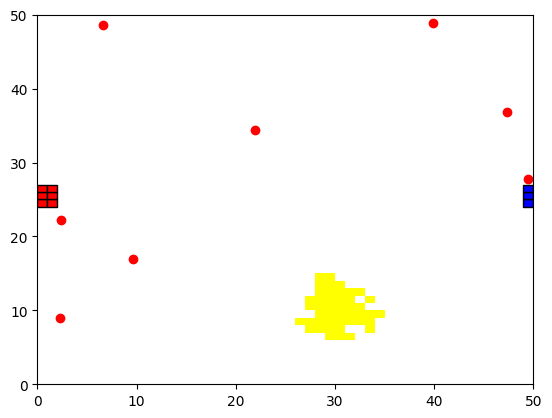

In [9]:
if __name__ == "__main__":
    main()